## Todo:

- update 'root_cause_discovery_high_dimensional' function to return final root cause score. 
- After that we can do simulations in high-dim settings (p=1000, n=300) to justify our real data results make sense (even though there are latent variable issue etc)

- Change the function 'root_cause_discovery_one_subject_all_perm' so that there is no need to decide threshold. 
- After that we can do simulations in low-dim settings (p=100, n=300).

- Address small issues in 'root_cause_discovery_one_subject_all_perm': ValueError: attempt to get argmax of an empty sequence Due to too small z-score: not larger than the threshold: add a condition in this case

- Change variable names to make them consistency: e.g., X_obs and Xobs

### This file is used as a test for later formal/extensive simulations

### Generate data by 

X <- mu_x+ BX +error + delta, 

or

X = (I-B)^{-1}* (mu_x + error + delta), 

with different kinds of B.

In [3]:
import numpy as np
import pandas as pd
from scipy import linalg
from tqdm import tqdm
import networkx as nx # draw DAG

# using chatGPT, we translated our julia code into the following python code

import random
from numpy import linalg as LA
from scipy.linalg import cholesky
from sklearn.linear_model import LassoCV, Lasso, lasso_path


# `obs_data` and `intv_data` are matrices
def zscore(obs_data, intv_data):
    if intv_data.ndim == 1:
        return zscore_vec(obs_data, intv_data)
    n, p = intv_data.shape
    assert obs_data.shape[1] == p, "Both inputs should have same number of variables"
    # observational data's mean and std
    mu = np.mean(obs_data, axis=0)
    sigma = np.std(obs_data, axis=0, ddof=1) # sample std
    # compute squared Z scores for each patient in interventional data
    zscore_intv = np.zeros((n, p))
    for i in range(n):
        zs = [(abs((intv_data[i, j] - mu[j]) / sigma[j]))**2 for j in range(p)]
        zscore_intv[i,:] = zs
    return zscore_intv

# `obs_data` is matrix, `intv_data` is vector
def zscore_vec(obs_data, intv_data):
    ngenes = len(intv_data)
    assert obs_data.shape[1] == ngenes, "Number of genes mismatch"
    # observational data's mean and std
    mu = np.mean(obs_data, axis=0)
    sigma = np.std(obs_data, axis=0)
    # compute squared Z scores for each patient in interventional data
    zs = [(abs((intv_data[i] - mu[i]) / sigma[i]))**2 for i in range(ngenes)]
    return zs

# `z` is a vector
def compute_permutations(z, threshold=2, nshuffles=1):
    # subset of variables indices that are abberent
    idx_abberent = [i for i, x in enumerate(z) if x > threshold]
    idx_abberent_copy = idx_abberent.copy()
    # subset of variables indices that are normal
    idx_normal = list(set(range(len(z))) - set(idx_abberent))
    # generate feasible permutations accroding to our theoretical results
    perms = []
    for i in range(len(idx_abberent)):
        for _ in range(nshuffles):
            random.shuffle(idx_normal)
            random.shuffle(idx_abberent)
            target = idx_abberent_copy[i]
            index = idx_abberent.index(target)
            idx_abberent[0], idx_abberent[index] = idx_abberent[index], idx_abberent[0]
            perms.append(idx_normal + idx_abberent)
    return perms


# `Xobs` is a matrix, `Xint` a vector, `perm` a permutation vector
def root_cause_discovery(Xobs, Xint, perm):
    if isinstance(perm, np.ndarray)==False:
        perm = np.array(perm)
    n, p = Xobs.shape
    assert p == len(Xint), "dimensions mismatch!"
    assert sorted(perm) == list(range(0, p)), "perm is not a permutation vector"
    # permute Xobs and Xint
    Xobs_perm = Xobs[:, perm]
    Xint_perm = Xint[perm]
    # estimate covariance and mean
    mu = np.mean(Xobs_perm, axis=0)
    if n > p:
        sigma = np.cov(Xobs_perm.transpose())
    else:
        raise Exception("covariance shrinkage not implemented")
    # ad-hoc way to ensure PSD
    min_eigenvalue = min(LA.eigvals(sigma))
    if min_eigenvalue < 1e-6:
        sigma = sigma + abs(min_eigenvalue) + 1e-6
    # compute cholesky
    L = LA.cholesky(sigma)
    # solve for Xtilde in L*Xtilde = Xint_perm - mu
    X_tilde = np.linalg.solve(L, Xint_perm - mu)
    # undo the permutations
    X_tilde = X_tilde[perm.argsort()]
    return abs(X_tilde)


def root_cause_discovery_one_subject_all_perm(Xobs, Xint, threshold, nshuffles=1, verbose=True):
    p = Xobs.shape[1]
    assert p == len(Xint), "Number of genes mismatch"
    # compute z scores
    z = zscore(Xobs, Xint)
    # compute permutations to try
    permutations = compute_permutations(z, threshold=threshold, nshuffles=nshuffles)
    if verbose: 
        print("Trying", len(permutations), "permutations")
    # try all permutations
    Xtilde_all = []
    for perm in permutations:
        Xtilde = root_cause_discovery(Xobs, Xint, perm)
        Xtilde_all.append(Xtilde)
    # assign the final root cause score for each variable
    root_cause_score = np.zeros(p)
    for i in range(len(Xtilde_all)):
        sorted_X = sorted(Xtilde_all[i])
        nonzero_quant_ratio = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
        max_index = np.argmax(Xtilde_all[i])
        if root_cause_score[max_index] < nonzero_quant_ratio:
            root_cause_score[max_index] = nonzero_quant_ratio
    # assign final root cause score for variables that never have maximal Xtilde_i
    idx1 = np.where(root_cause_score != 0)[0]
    idx2 = np.where(root_cause_score == 0)[0]
    max_RC_score_idx2 = np.min(root_cause_score[idx1]) - 0.0001
    z_array = np.array(z)
    root_cause_score[idx2] = z_array[idx2] / (np.max(z_array[idx2]) / max_RC_score_idx2)
    return root_cause_score


# `Xall` is a vector of vectors
def find_largest(Xall):
    largest = [sorted(X, reverse=True)[0] for X in Xall]
    largest_idx = [np.argmax(X) for X in Xall]
    return largest, largest_idx


# `Xall` is a vector of vectors
def find_second_largest(Xall):
    second_largest = [sorted(X, reverse=True)[1] for X in Xall]
    return second_largest


# this is same function as reduce_gene
def reduce_dimension(y_idx, Xobs, Xint, method, verbose=True):
    n, p = Xobs.shape
    # response and design matrix for Lasso
    y = Xobs[:, y_idx]
    X = np.delete(Xobs, y_idx, axis=1)
    # fit lasso
    if method == "cv":
        lasso_cv = LassoCV().fit(X, y)
        beta_final = lasso_cv.coef_
    elif method == "largest_support":
        _, coef_path, _ = lasso_path(X, y)
        beta_final = coef_path[:, -1]
    else:
        raise ValueError("method should be `cv` or `largest_support`")
    nz = np.count_nonzero(beta_final)
    if verbose:
        print("Lasso found ", nz, " non-zero entries")
    # for non-zero idx, find the original indices in Xobs, and don't forget to include y_idx
    selected_idx = np.nonzero(beta_final)[0]
    selected_idx = np.array([idx + 1 if idx >= y_idx else idx for idx in selected_idx])
    selected_idx = np.append(selected_idx, y_idx)
    # return the subset of variables of Xobs that were selected
    Xobs_new = Xobs[:, selected_idx]
    Xint_sample_new = Xint[selected_idx]
    # return
    return Xobs_new, Xint_sample_new, selected_idx

# returns: a rank for each variable (1st variable = most likely to be root cause, ... etc)
def root_cause_discovery_high_dimensional(
        Xobs, 
        Xint,
        method,
        y_idx_z_threshold=1.5,
        permutation_thresholds=np.arange(0.1, 5, 0.2),
        nshuffles=1,
        verbose=True):
    n, p = Xobs.shape
    z = zscore(Xobs, Xint)
    y_indices = np.where(z > y_idx_z_threshold)[0]
    if verbose:
        print(f"Trying {len(y_indices)} y_indices")
    # check for desired pattern
    record_match = np.zeros(len(y_indices))
    for (i, y_idx) in enumerate(y_indices):
        best_permutation_score = 0.0
        best_Xtilde = []
        # treat one column of Xobs as response
        Xobs_new, Xint_sample_new, _ = reduce_dimension(
            y_idx, Xobs, Xint, method
        )
        # try different permutations
        for thrs in permutation_thresholds:
            cholesky_score = root_cause_discovery_one_subject_all_perm(Xobs_new, 
                                                            Xint_sample_new, 
                                                            threshold=thrs,
                                                            nshuffles=nshuffles,
                                                            verbose=verbose)
            sorted_X = sort(cholesky_score)
            current_score = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
            if current_score > best_permutation_score:
                best_permutation_score = current_score
                best_Xtilde = cholesky_score
        # check if the discovered "root cause" in best_Xtilde matches y_idx
        if np.argmax(best_Xtilde) == y_idx:
            record_match[i] = 1
    # compare z score and record_match to determine rank of each var
    original_rank = z.argsort().argsort()
    offset = len(setdiff1d(range(p), y_indices)) + np.sum(record_match == 0)
    variable_rank = []
    for (i, zi) in enumerate(z):
        used_as_response = i in y_indices
        used_as_response_and_matched = (used_as_response and record_match[np.where(y_indices == i)] == 1)[0]
#         if used_as_response:
    # todo: return a Z-score modified rank
    return best_Xtilde, y_indices


In [4]:
################### Randomly generate lower triangular matrix B
def B_random(p, s_B, B_value_min, B_value_max):
    lowertri_index = np.nonzero(np.tril(np.ones((p,p)),-1))
    num_lowertri_entry = len(lowertri_index[0])
    num_nonzero_entry = int(s_B * num_lowertri_entry)
    nonzero_index = np.random.choice(num_lowertri_entry, num_nonzero_entry, replace=False)
    B = np.zeros((p,p))
    B[lowertri_index[0][nonzero_index], lowertri_index[1][nonzero_index]] = np.random.uniform(B_value_min, B_value_max, num_nonzero_entry)

    return B

################### Randomly generate lower triangular matrix B corresponds to a hub graph
def B_hub_func(num_hub, size_up_block, size_low_block, intersect_prop, s_B, B_value_min, B_value_max):
    if num_hub < 2:
        intersect_prop = 0
    p = num_hub + num_hub * (size_up_block + size_low_block)
    B = np.zeros((p, p))
    B_upper_list, B_lower_list, hub_B_in_vec, hub_B_out_vec = [], [], [], []
    hub_size_in = size_up_block+int(size_up_block*intersect_prop) # point to hubs
    hub_size_out = size_low_block+int(size_low_block*intersect_prop) # hubs point to other nodes
    
    for i in range(num_hub):
        B_upper_list.append(B_random(size_up_block, s_B, B_value_min, B_value_max))
        B_lower_list.append(B_random(size_low_block, s_B, B_value_min, B_value_max))        
        hub_B_in_vec.append(np.random.uniform(B_value_min, B_value_max, hub_size_in))
        hub_B_out_vec.append(np.random.uniform(B_value_min, B_value_max, hub_size_out))
    
    for i in range(num_hub):
        start_index_up = i*size_up_block
        B[start_index_up:(start_index_up+size_up_block), start_index_up:(start_index_up+size_up_block)] = B_upper_list[i]
    
    for i in range(num_hub):
        start_index_in_row = num_hub*size_up_block+i
        start_index_in_col = max(0, i*size_up_block - int(size_up_block*intersect_prop))
        B[start_index_in_row, start_index_in_col:(start_index_in_col+len(hub_B_in_vec[i]))] = hub_B_in_vec[i]
    
        start_index_out_row = num_hub*size_up_block+num_hub + max(0, i*size_low_block - int(size_low_block*intersect_prop))
        start_index_out_col = num_hub*size_up_block+i
        B[start_index_out_row:(start_index_out_row+len(hub_B_out_vec[i])), start_index_out_col] = hub_B_out_vec[i]
    
    for i in range(num_hub):
        start_index_low = num_hub*size_up_block + num_hub + i*size_low_block
        B[start_index_low:(start_index_low+size_low_block), start_index_low:(start_index_low+size_low_block)] = B_lower_list[i]
    
    return B

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
def rescale_B_func(B, var_X_design, sigma2_error, tol, step_size, max_count):
    p = B.shape[1]
    I = np.identity(p)
    
    var_X_ori = np.diag( np.dot( linalg.solve(I - B, np.diag(sigma2_error)), linalg.inv(I - B).T ) )

    for i in range(p):
        if np.sum(B[i]) == 0: 
            sigma2_error[i] = var_X_design[i]
        elif np.sum(B[i]) > 0:  # if not a source node
            count_while = 0
            rescale_temp = np.sqrt(np.abs(var_X_ori[i] - sigma2_error[i]))
            B_temp = B.copy()
            
            IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
            var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

            while abs(var_temp - var_X_design[i]) > tol:
                if var_temp - var_X_design[i] > 0:
                    rescale_temp = rescale_temp * (1 + step_size)
                    B_temp = B.copy()
                    B_temp[i] = B_temp[i]/rescale_temp

                    IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
                    var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

                if var_temp - var_X_design[i] < 0:
                    rescale_temp = rescale_temp * (1 - step_size)
                    B_temp = B.copy()
                    B_temp[i] = B_temp[i]/rescale_temp

                    IB_inv_temp = linalg.solve(I - B_temp, np.eye(p))
                    var_temp = (IB_inv_temp[i] * sigma2_error) @ IB_inv_temp[i].T

                count_while += 1
                if count_while > max_count:
                    break
            
            B = B_temp  # update B

    return B, sigma2_error

# Generate n observartional data and m interventional data

def generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd):
    # True root causes
    RC = np.random.choice(np.arange(p), size=m, replace=True)
    I = np.identity(p)
    
    X_obs = np.zeros((n,p))
    X_int = np.zeros((m,p))
    for i in range(n):
        error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
        X_obs[i,:] = linalg.solve(I - B, (b + error).T).reshape(p)
    for i in range(m):
        delta = np.repeat(0, p)
        delta[RC[i]] = np.random.normal(int_mean, int_sd, 1)
        error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
        X_int[i,:] = linalg.solve(I - B, (b + error + delta).T).reshape(p)
    
    return X_obs, X_int, RC

################### Randomly generate lower triangular matrix B corresponds to a hub graph


### Random DAG case

[ 6.34141513  9.60543013  7.71203856  9.40865716  6.12351009  9.97070344
 20.4407426  32.2648621   9.56835196  4.94128038]
[6.34141513 9.26306555 8.233333   8.79558873 5.95100349 5.84784247
 6.91558327 7.70655498 9.84557714 5.25309156]


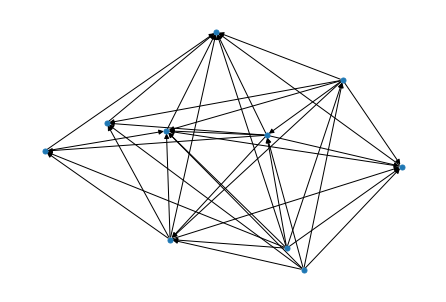

In [5]:
############## Generate b, B and sigma2_error used in the SEM
p = 10
int_mean = 20
int_sd = 1
s_B = 0.8
B_value_min = -1
B_value_max = 1

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_random(p, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
var_err_min = 1
var_err_max = 2
var_X_min = 5
var_X_max = 10

sigma2_error_raw = np.random.uniform(var_err_min, var_err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_raw, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=1, step_size=0.3, max_count=30)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
print(np.diag( np.dot( linalg.solve(I - B_raw, np.diag(sigma2_error_raw)), linalg.inv(I - B_raw).T ) ) ) # variance of X based on B_raw
print(var_X_design)

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_raw @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_raw[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

### Implement our method based on the simulated data

In [30]:
n = 200
m = 100
X_obs, X_int, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)

/tmp/ipykernel_14663/1113173493.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta[RC[i]] = np.random.normal(int_mean, int_sd, 1)


In [31]:
print(X_obs.shape, X_int.shape)

(200, 52) (100, 52)


In [32]:
obs_data = X_obs
Xobs = X_obs
intv_data = X_int
Xint = X_int
Zscores = zscore(obs_data, intv_data)

In [33]:
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [34]:
np.random.seed(2024)
threshold = 1
Final_RC_scores = np.zeros((X_int.shape))
for i in tqdm(range(X_int.shape[0])):
    Final_RC_scores[i,:] = root_cause_discovery_one_subject_all_perm(Xobs, X_int[i,:], threshold, nshuffles=5, verbose=False)

100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


In [35]:
#print(np.round(Final_RC_scores, 1))
max_index_Chol = [np.argmax(Final_RC_scores[i,:]) for i in range(Final_RC_scores.shape[0])]

In [36]:
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Zscore, num_success_Chol)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

71 86


In [53]:
RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

RC_rank_Chol = [np.sum(Final_RC_scores[i,RC[i]] < Final_RC_scores[i,:]) 
 for i in range(Final_RC_scores.shape[0])]

#### Hub DAG case

[  0.  -4.  -4.  -3.  -2.   2.  -3.   3.  -2.  -3.  -1.  -3.  40.  49.
  35.   0.   0.  -2.   4.   3.  -4.   0.   0.  43.   3.  -2.   4. 102.
  -3. 158.  -2. 303.  -8.  -3.  -8.  -1.  -6.  -0.   7. 112.  -5. 195.
  91.  -2. 370. 110. 266.  -4.  14.  -6.  -3.  -5.]


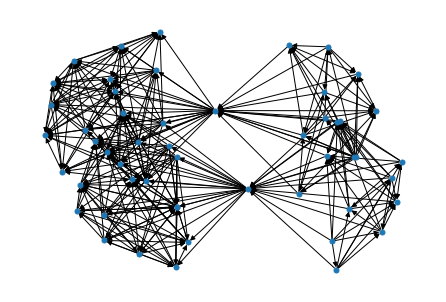

In [20]:
### Parameters for B_hub
num_hub = 2 # same number of upper and lower blocks
s_B = 0.8
B_value_min = -1
B_value_max = 1

size_up_block = 15
size_low_block = 10
intersect_prop = 0.3
p = num_hub + num_hub * (size_up_block + size_low_block)
f"{p=}"

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_hub_func(num_hub, size_up_block, size_low_block, intersect_prop, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
var_err_min = 1
var_err_max = 2
var_X_min = 5
var_X_max = 10

sigma2_error_raw = np.random.uniform(var_err_min, var_err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_raw, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=5, step_size=0.0001, max_count=300)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
var_X_Braw = np.diag( np.dot( linalg.solve(I - B_raw, np.diag(sigma2_error_raw)), linalg.inv(I - B_raw).T ) ) 
print(np.round(var_X_Braw - var_X_design,0))

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_raw @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_raw[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

In [22]:
n = 200
m = 10
int_mean = 20
int_sd = 1
X_obs, X_int, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)

/tmp/ipykernel_14663/1113173493.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta[RC[i]] = np.random.normal(int_mean, int_sd, 1)


In [23]:
print(X_obs.shape, X_int.shape)

(200, 52) (10, 52)


In [24]:
obs_data = X_obs
Xobs = X_obs
intv_data = X_int
Xint = X_int
Zscores = zscore(obs_data, intv_data)

In [25]:
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [26]:
np.random.seed(2024)
threshold = 1
Final_RC_scores = np.zeros((X_int.shape))
for i in tqdm(range(X_int.shape[0])):
    Final_RC_scores[i,:] = root_cause_discovery_one_subject_all_perm(Xobs, X_int[i,:], threshold, nshuffles=5, verbose=False)

100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


In [27]:
#print(np.round(Final_RC_scores, 1))
max_index_Chol = [np.argmax(Final_RC_scores[i,:]) for i in range(Final_RC_scores.shape[0])]

In [28]:
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Zscore, num_success_Chol)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

8 9
